In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd
import os 
import re

from bids import BIDSLayout

from sklearn.model_selection import cross_val_score, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder

from util.decoding.gee import GEEEstimator
from mne_ari import all_resolutions_inference
from mne.decoding import (
    cross_val_multiscore, 
    LinearModel,                  
    SlidingEstimator, 
    GeneralizingEstimator,
    get_coef
)
from mne.viz.utils import _plot_masked_image
from mne import set_config
from mne.stats.cluster_level import _find_clusters, _cluster_indices_to_mask
set_config('MNE_MEMMAP_MIN_SIZE', '1M')
set_config('MNE_CACHE_DIR', '.tmp')
import mne

In [2]:
# hard-coded values
BIDS_ROOT = 'bids_dataset'
DERIV_ROOT = os.path.join(BIDS_ROOT, 'derivatives')

In [3]:
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
subjects = layout.get_subjects(scope = 'preprocessing')
subjects.sort()
task = layout.get_tasks()[0]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/bids/layout/validation.py:156: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


In [4]:
def load_subj_data(layout, sub):
    
    epochs_fpath = layout.get(
        scope = 'preprocessing', 
        subject = sub, 
        suffix = 'epo', 
        extension = 'fif.gz', 
        return_type = 'filename')[0]
    epochs = mne.read_epochs(epochs_fpath, preload = True, verbose = False)
    X = epochs.get_data() 
    y = epochs.events[:, 2] 
    
    return X, y, epochs


In [5]:
X = []
y = []
sub_ids = []
for sub in subjects:
    sub_num = int(sub)
    _X, _y, epochs = load_subj_data(layout, sub)
    X.append(_X)
    y.append(_y)
    sub_ids.append(np.full_like(_y, sub_num))
X = np.concatenate(X)
y = np.concatenate(y)
sub_ids = np.concatenate(sub_ids)

In [6]:
# define classification pipeline
logistic_reg = GEEEstimator(family = 'binomial', cov_type = 'naive')
clf = LinearModel(logistic_reg)
time_decod = GeneralizingEstimator(clf, n_jobs = 5, scoring = 'roc_auc', verbose = True)

In [7]:
# perform cross-validation across subjects
cv_methds = [StratifiedGroupKFold(10, shuffle = True, random_state = i) for i in range(10)]
optim_params = dict(maxiter = 100, first_dep_update = 20, params_niter = 10)
scores = [cross_val_multiscore(
    time_decod, 
    X, y, sub_ids,
    fit_params = dict(groups = sub_ids, **optim_params),
    n_jobs = 1,
    cv = cv) for cv in cv_methds
]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

In [8]:
# train final model for visualization
time_decod.fit(X, y, groups = sub_ids)
# extract "patterns," not model weights, see Haufe et al. (2014)
pat = get_coef(time_decod, 'patterns_') 
patterns = mne.EvokedArray(pat, epochs.info, tmin = epochs.times[0])
patterns.nave = None

dig = mne.channels.make_standard_montage('standard_1020')
patterns = patterns.set_montage(dig)

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

In [120]:
def ttest_1samp_corrected(scores, chance = .5):
    '''
    Performs one-sample t-test using the variance correction
    proposed by [1] to correct for the issues caused by 
    overlapping training/test sets across folds (violating 
    independence assumption of a t-test [2]). Recommended 
    cross-validation procedure for good replicability is
    10 times 10-fold cross-validation [3], but the test 
    should be conservative for other r x k-fold schemes.
    
    Input: list of r (k, n_tests) arrays of scores obtained from
            a series of r different k-fold cross validation splits
            
    Output: t-values, p-values, and standard errors from 
            a kx2 t-test for classification metrics with null
            hypothesis that metric == 0.5. These are all
            (n_tests,) arrays. Corrected t-stat derived 
            in [1] and described more readably, with a 
            k-fold formulation given in [3]
            
    References
    ----------
    [1] Nadeau, C., & Bengio, Y. (1999). Inference for the 
        generalization error. Advances in neural information 
        processing systems, 12.
    [2] Dietterich T.G. (1998) Approximate Statistical Tests for 
        Comparing Supervised Classification Learning Algorithms.
        Neural Comput 10:1895–1923
    [3] Bouckaert, R. R., & Frank, E. (2004, May). 
        Evaluating the replicability of significance tests for 
        comparing learning algorithms. In Pacific-Asia conference on 
        knowledge discovery and data mining (pp. 3-12). 
        Springer, Berlin, Heidelberg.
    '''
    from scipy.stats import t as t_dist
    r = len(scores) # number of cross-validation runs
    k = scores[0].shape[0] # number of cross-validation folds
    test_train_ratio = 1/(k - 1)
    scrs = np.concatenate(scores)
    above_chance = scrs - chance
    mean_scr = above_chance.mean(axis = 0)
    var_scr = above_chance.var(axis = 0)
    se_corrected = np.sqrt((1/(k*r) + test_train_ratio) * var_scr)
    t = mean_scr / se_corrected
    p = t_dist.sf(t, df = r*k - 1) # one-sided p-value 
    return t, p, mean_scr + chance, se_corrected

# evaluate statistical significance of CV results
alpha = .05
_, p, obs_scores, se = ttest_1samp_corrected(scores)
# and correct for multiple comparisons 
_, tdp, clusters = all_resolutions_inference(
    p[np.newaxis, :], alpha, 
    statfun = lambda x: np.squeeze(x), 
    ari_type = 'parametric',
    thresholds = 'all'
)

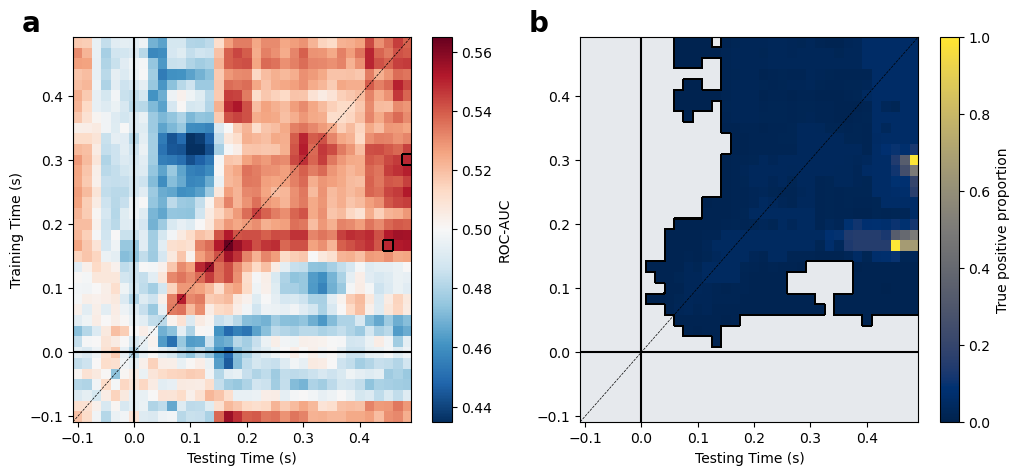

In [128]:
## plot time-by-time generalization results
mm = np.min(obs_scores[:]), np.max(obs_scores[:])
delta = np.abs(.5 - np.max(mm))
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
im, _ = _plot_masked_image(
    ax[0], 
    obs_scores, 
    times = epochs.times, 
    yvals = epochs.times,
    mask = np.any(np.stack(clusters), axis = 0),
    mask_alpha = 1.,
    mask_cmap = 'RdBu_r',
    vmin = .5 - delta, vmax = .5 + delta
)
ax[0].set_xlabel('Testing Time (s)')
ax[0].set_ylabel('Training Time (s)')
#ax[0].set_title('Temporal generalization')
ax[0].axvline(0, color = 'k')
ax[0].axhline(0, color = 'k')
ax[0].axline(
    (0, 0), slope = 1, 
    color = 'k', 
    linestyle = '--', 
    linewidth = .5
)
ax[0].text(-0.2, .5, 'a', size=20, weight = 'bold')
cbar = plt.colorbar(im, ax = ax[0])
cbar.set_label('ROC-AUC')

tdp_cmap = 'cividis'
im, _ = _plot_masked_image(
    ax[1], 
    tdp, 
    times = epochs.times, 
    yvals = epochs.times,
    cmap = tdp_cmap,
    mask = tdp > 0.01,
    mask_alpha = 0.1,
    mask_cmap = tdp_cmap,
    vmin = 0., vmax = 1.
)
ax[1].set_xlabel('Testing Time (s)')
#ax[1].set_title('True discovery proportion')
ax[1].axvline(0, color = 'k')
ax[1].axhline(0, color = 'k')
ax[1].axline(
    (0, 0), slope = 1, 
    color = 'k', 
    linestyle = '--', 
    linewidth = .5
)
ax[1].text(-0.2, .5, 'b', size = 20, weight = 'bold')
cbar = plt.colorbar(im, ax = ax[1])
cbar.set_label('True positive proportion')

plt.show()

No projector specified for this dataset. Please consider the method self.add_proj.


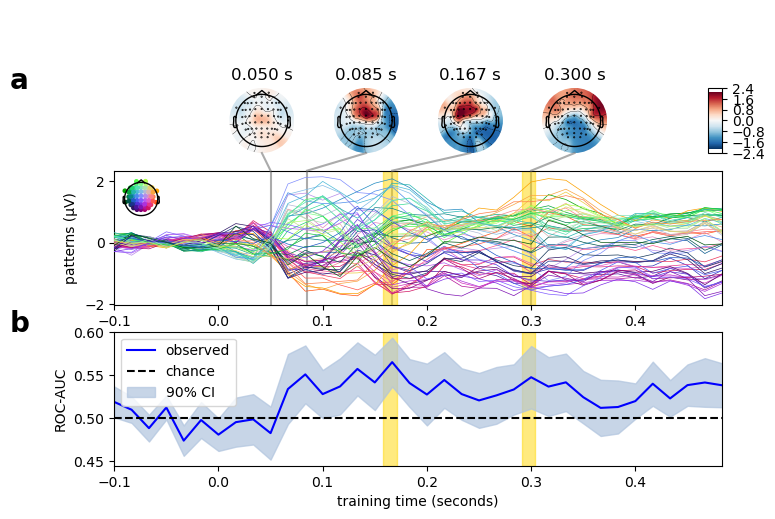

Cluster 1: 167 to 167 ms, observed score = 0.565, p <= 0.00013620323815151877
Cluster 2: 300 to 300 ms, observed score = 0.549, p <= 3.528993516639651e-05


In [130]:
## plot time-by-time decoding results
scores_1d = np.diag(obs_scores)
se_1d = np.diag(se)
# find training times that pass ARI correction at some test time
mask = np.any(np.stack(clusters), axis = 0)
mask_1d = np.any(mask, axis = 1)
clusters_1d, _ = _find_clusters(mask_1d, threshold = .95, tail = 1)
clusters_1d = _cluster_indices_to_mask(clusters_1d, mask_1d.size)
# get p-val for best test performance for each training time
t_idxs = np.arange(obs_scores.shape[0])
max_idx = np.argmax(obs_scores, axis = 1)
p_1d = p[t_idxs, max_idx]
max_scores = obs_scores[t_idxs, max_idx]

# determine which times to highlight 
fs = epochs.info['sfreq']
t_start = []
t_end = []
t = []
for i, clust in enumerate(clusters_1d):
    times = epochs.times[clust]
    t_start.append(min(times))
    t_end.append(max(times))
    t.append((t_start[i] + t_end[i])/2)
t = [.05, .085] + t

# build axes
n_maps = len(t)
fig = plt.figure(figsize = None)
pat_ax = fig.add_subplot(312)
ts = n_maps + 2
map_ax = [plt.subplot(6, ts, x + 2 + ts) for x in range(n_maps)]
cbar_ax = plt.subplot(6, 5 * (ts + 1), 10 * (ts + 1))
auc_ax = fig.add_subplot(313)

# plot patterns
fig = patterns.plot_joint(
    t, 
    show = False, 
    title = ' ',
    ts_args = dict(axes = pat_ax),
    topomap_args = dict(
        axes = map_ax + [cbar_ax]
    )
)
pat_ax.set_ylabel('patterns (µV)')

# plot decoding performance
z = norm.ppf(1 - alpha)
auc_ax.set_xlim(pat_ax.get_xlim())
auc_ax.plot(epochs.times, scores_1d, color = 'blue', label = 'observed')
auc_ax.axhline(.5, color = 'black', linestyle = '--', label = 'chance')
upper = scores_1d + z*se_1d
lower = scores_1d - z*se_1d
auc_ax.fill_between(
    epochs.times, 
    upper, lower, 
    color = 'lightsteelblue', 
    alpha = .7, 
    label = '90% CI'
)
auc_ax.set_xlabel('training time (seconds)')
auc_ax.set_ylabel('ROC-AUC')
auc_ax.legend(loc = 'upper left')


for i, clust in enumerate(clusters_1d):
    pat_ax.axvspan(t_start[i] - .5/fs, t_end[i]+ .25/fs, 
               alpha = .5, color = 'gold', zorder = 0)
    auc_ax.axvspan(t_start[i] - .5/fs, t_end[i]+ .25/fs, 
               alpha = .5, color = 'gold', zorder = 0)
    

pat_ax.text(-0.2, 5, 'a', size = 20, weight = 'bold') 
auc_ax.text(-0.2, .6, 'b', size = 20, weight = 'bold') 
    
plt.show()

# print adjusted alphas for cluster inclusion
for i, clust in enumerate(clusters_1d):
    scr = max_scores[clust].mean() # average within cluster 
    print(
        'Cluster {:d}: {:.0f} to {:.0f} ms, observed score = {:.3f},'.format(
            i + 1, 1e3*t_start[i], 1e3*t_end[i], scr
        ) + ' p <= ' + str(p_1d[clust].max())
    )

In [12]:
## explore model predictors using Wald's test

ch_names = epochs.info.ch_names
areas = np.array([re.findall('\D+', ch)[0] for ch in ch_names])
area_ps = {}
unique_areas = np.unique(areas)
for a in unique_areas:
    chs = (areas == a)
    aps = [lm.model.wald_test(chs)[1] for lm in time_decod.estimators_]
    area_ps[a] = np.array(aps)

all_ps = np.stack([area_ps[area] for area in unique_areas])
reject, _ = mne.stats.fdr_correction(all_ps)
print('FDR-adjusted alpha: ' + str(all_ps[reject].max().round(5)))
t = []
for i, area in enumerate(unique_areas):
    if np.any(reject[i]):
        print('\nIntervals for %s electrodes:'%area)
        clusts, _ = _find_clusters(reject[i], threshold = .95, tail = 1)
        clusts = _cluster_indices_to_mask(clusts, reject[i].size)
        for clust in clusts:
            ts = epochs.times[clust]
            t_start = ts.min() * 1e3
            t_end = ts.max() * 1e3
            t.append((t_start + t_end)/2 * 1e-3)
            print('{:.0f} to {:.0f} ms'.format(t_start, t_end))
t.sort()
            
area_mask = np.zeros_like(pat) # ch x time
for i, area in enumerate(unique_areas):
    chs = (areas == area)
    area_mask[chs] = reject[i]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


FDR-adjusted alpha: 0.00094

Intervals for C electrodes:
117 to 133 ms

Intervals for CP electrodes:
267 to 267 ms

Intervals for F electrodes:
67 to 83 ms

Intervals for FC electrodes:
83 to 83 ms
267 to 317 ms

Intervals for FT electrodes:
67 to 100 ms

Intervals for P electrodes:
117 to 117 ms
